# Classifying images

## Import

In [1]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

## Architecture class

In [2]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

## Data Generation

In [3]:
def gen_img(start, target, fill=1, img_size=10):
    # Create an image of specified size filled with zeros, data type is float for pixel values.
    img = np.zeros((img_size, img_size), dtype=float)

    # Initialize start_row and start_col to None. They are used to determine the drawing start point.
    start_row, start_col = None, None

    # If start is positive, it indicates a row, else start_col is the absolute value of start.
    if start > 0:
        start_row = start
    else:
        start_col = np.abs(start)

    # If target is 0, fill a row or column based on whether start is a row or a column.
    if target == 0:
        if start_row is None:
            img[:, start_col] = fill  # Fill the entire column with 'fill' value.
        else:
            img[start_row, :] = fill  # Fill the entire row with 'fill' value.
    else:
        # If start_col is 0, adjust to 1 to prevent out of index errors for negative indices.
        if start_col == 0:
            start_col = 1

        # If target is 1, fill diagonally upwards depending on start_row or start_col.
        if target == 1:
            if start_row is not None:
                up = (range(start_row, -1, -1),  # Decrement row index from start_row to 0.
                      range(0, start_row + 1))  # Increment column index from 0 to start_row.
            else:
                up = (range(img_size - 1, start_col - 1, -1),  # Decrement row index starting near the bottom.
                      range(start_col, img_size))  # Increment column index from start_col to the end.
            img[up] = fill
        else:
            # If target is not 1, fill diagonally downwards depending on start_row or start_col.
            if start_row is not None:
                down = (range(start_row, img_size, 1),  # Increment row index from start_row to the end.
                        range(0, img_size - start_row))  # Increment column index across the available width.
            else:
                down = (range(0, img_size - 1 - start_col + 1),  # Increment row index from 0 to an adjusted max.
                        range(start_col, img_size))  # Increment column index from start_col to the end.
            img[down] = fill

    # Multiply all pixel values by 255 (for visualizing if needed) and reshape to a 3D array suitable for image handling.
    return 255 * img.reshape(1, img_size, img_size)

In [4]:
def generate_dataset(img_size=10, n_images=100, binary=True, seed=17):
    """
    Generates a dataset of images with specified patterns and corresponding target values.

    This function creates a dataset consisting of images generated based on random start positions
    and target patterns. Each image is created using the `gen_img` function which defines
    different filling patterns based on the target value. The function allows for control over the
    size of the images, the number of images, whether the targets are binary, and the random seed
    for reproducibility.

    Parameters:
        img_size (int): Size of the square image (default is 10x10 pixels).
        n_images (int): Number of images to generate in the dataset.
        binary (bool): If True, target values will be converted to binary (0, 1).
                       0 remains 0, and 1 or 2 are converted to 1. Default is True.
        seed (int): Seed for random number generation to ensure reproducibility. Default is 17.

    Returns:
        tuple: A tuple containing two elements:
            - numpy.ndarray: An array of images, each shaped as (1, img_size, img_size) and having uint8 type.
            - numpy.ndarray: An array of target values, either integer (0, 1, 2) or binary (0, 1),
                             based on the 'binary' parameter.

    Example:
        >>> images, targets = generate_dataset(img_size=8, n_images=50, binary=False, seed=42)
        >>> print(images.shape)
        (50, 1, 8, 8)
        >>> print(targets)
        [2, 0, 1, ...]
    """
    # Set the random seed for reproducibility of results
    np.random.seed(seed)

    # Generate random 'start' positions for each image within the allowed range.
    # Negative values indicate columns, positive values indicate rows.
    starts = np.random.randint(-(img_size - 1), img_size, size=(n_images,))

    # Generate random 'target' codes for each image. The target dictates the filling pattern:
    # 0 = fill a row or column, 1 = fill diagonally up, 2 = fill diagonally down.
    targets = np.random.randint(0, 3, size=(n_images,))

    # Create an array of images. For each start and target pair, generate an image using the gen_img function.
    images = np.array([gen_img(s, t, img_size=img_size)
                       for s, t in zip(starts, targets)], dtype=np.uint8)

    # If binary is True, convert the targets to a binary format:
    # 0 remains 0, 1 and 2 are converted to 1. This is typically used for classification tasks.
    if binary:
        targets = (targets > 0).astype(int)

    # Return the array of generated images and the possibly converted target array.
    return images, targets

In [5]:
def plot_images(images, targets, n_plot=30):
    n_rows = n_plot // 6 + ((n_plot % 6) > 0)
    fig, axes = plt.subplots(n_rows, 6, figsize=(9, 1.5 * n_rows))
    axes = np.atleast_2d(axes)

    for i, (image, target) in enumerate(zip(images[:n_plot], targets[:n_plot])):
        row, col = i // 6, i % 6
        ax = axes[row, col]
        ax.set_title('#{} - Label:{}'.format(i, target), {'size': 12})
        # plot filter channel in grayscale
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

    plt.tight_layout()
    return fig

In [6]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

In [7]:
images[0]

array([[[  0,   0, 255,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0, 255,   0,   0]]], dtype=uint8)

In [8]:
labels[0]

0

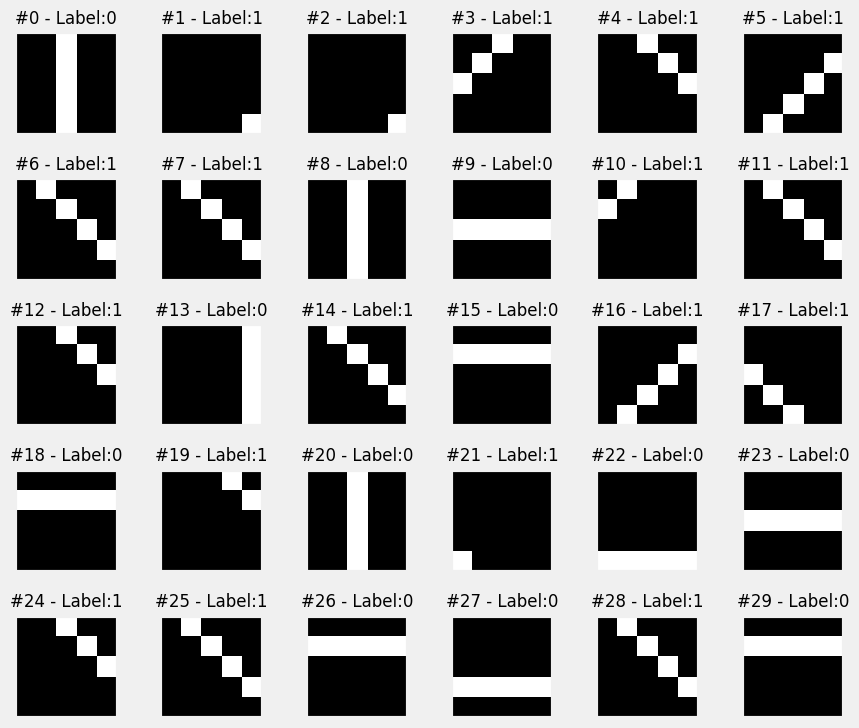

In [9]:
fig = plot_images(images, labels, n_plot=30)

### Images and Channels

In [10]:
def image_channels(red, green, blue, rgb, gray, rows=(0, 1, 2)):
    fig, axs = plt.subplots(len(rows), 4, figsize=(15, 5.5))

    zeros = np.zeros((5, 5), dtype=np.uint8)

    titles1 = ['Red', 'Green', 'Blue', 'Grayscale Image']
    titles0 = ['image_r', 'image_g', 'image_b', 'image_gray']
    titles2 = ['as first channel', 'as second channel', 'as third channel', 'RGB Image']

    idx0 = np.argmax(np.array(rows) == 0)
    idx1 = np.argmax(np.array(rows) == 1)
    idx2 = np.argmax(np.array(rows) == 2)

    for i, m in enumerate([red, green, blue, gray]):
        if 0 in rows:
            axs[idx0, i].axis('off')
            axs[idx0, i].invert_yaxis()
            if (1 in rows) or (i < 3):
                axs[idx0, i].text(0.15, 0.25, str(m.astype(np.uint8)), verticalalignment='top')
                axs[idx0, i].set_title(titles0[i], fontsize=16)

        if 1 in rows:
            axs[idx1, i].set_title(titles1[i], fontsize=16)
            axs[idx1, i].set_xlabel('5x5', fontsize=14)
            axs[idx1, i].imshow(m, cmap=plt.cm.gray)

        if 2 in rows:
            axs[idx2, i].set_title(titles2[i], fontsize=16)
            axs[idx2, i].set_xlabel(f'5x5x3 - {titles1[i][0]} only', fontsize=14)
            if i < 3:
                stacked = [zeros] * 3
                stacked[i] = m
                axs[idx2, i].imshow(np.stack(stacked, axis=2))
            else:
                axs[idx2, i].imshow(rgb)

        for r in [1, 2]:
            if r in rows:
                idx = idx1 if r == 1 else idx2
                axs[idx, i].set_xticks([])
                axs[idx, i].set_yticks([])
                for k, v in axs[idx, i].spines.items():
                    v.set_color('black')
                    v.set_linewidth(.8)

    if 1 in rows:
        axs[idx1, 0].set_ylabel('Single\nChannel\n(grayscale)', rotation=0, labelpad=40, fontsize=12)
        axs[idx1, 3].set_xlabel('5x5 = 0.21R + 0.72G + 0.07B')
    if 2 in rows:
        axs[idx2, 0].set_ylabel('Three\nChannels\n(color)', rotation=0, labelpad=40, fontsize=12)
        axs[idx2, 3].set_xlabel('5x5x3 = (R, G, B) stacked')
    fig.tight_layout()
    return fig

In [11]:
image_r  = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [12]:
image_gray = .2126*image_r + .7152*image_g + .0722*image_b

In [13]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

In [14]:
image_rgb.shape

(5, 5, 3)

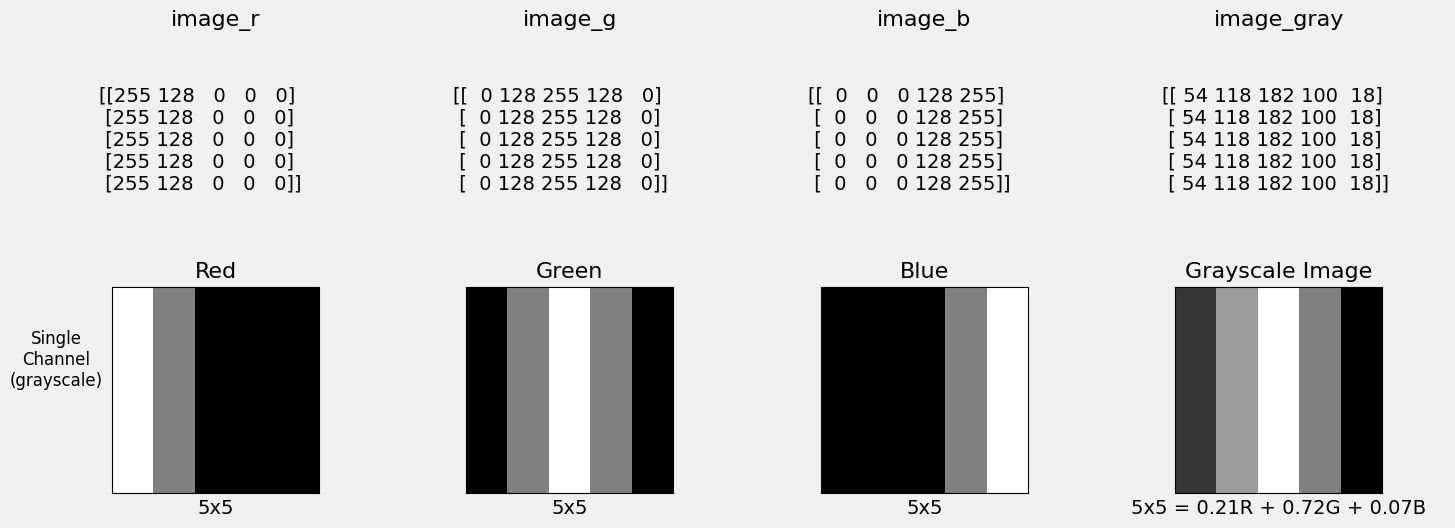

In [15]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))

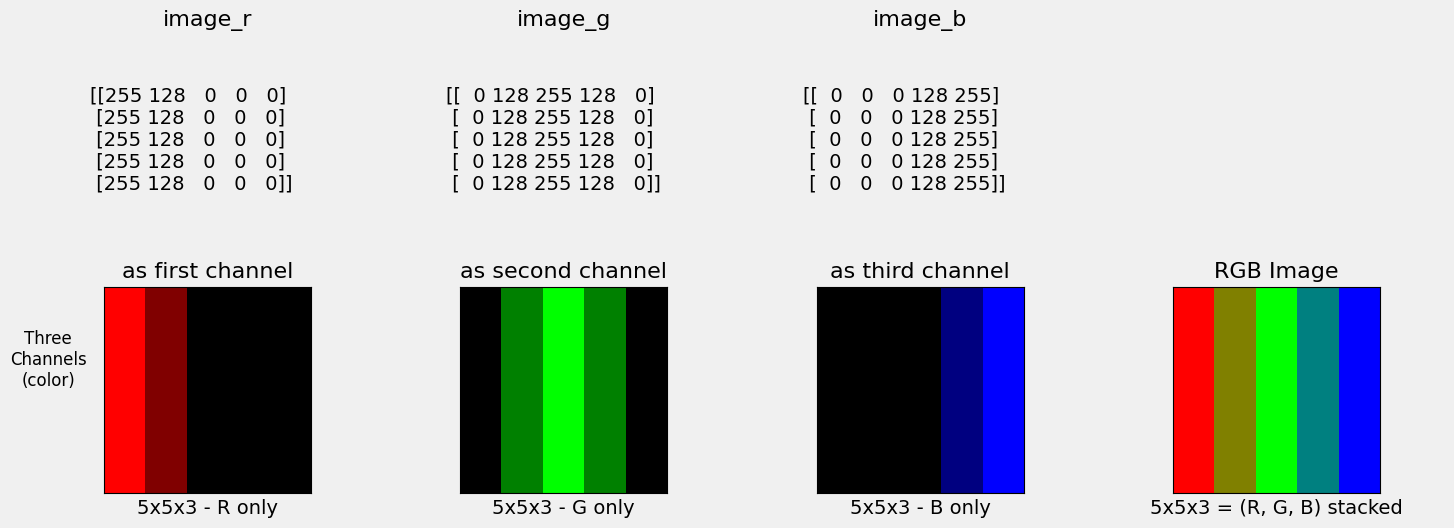

In [16]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

#### NCHW vs NHWC

In [17]:
images.shape

(300, 1, 5, 5)

In [18]:
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [19]:
# PIL shape
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape

(5, 5, 1)

In [20]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

## Torchvision

In [21]:
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import Normalize, ToPILImage
from torchvision.transforms import RandomHorizontalFlip, Resize

### Transforms

> **ToTensor()** may scale the values from a [0, 255] range to a [0.0, 1.0] range if the input is either a Numpy array with dtype equal to uint8 (as in our example) or a PIL image belonging to one of the
following modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK).

In [22]:
# ToTensor() to convert a Numpy array (in PIL shape) to a
# PyTorch tensor.
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [23]:
print(type(example_tensor))
example_tensor

<class 'torch.Tensor'>


tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [24]:
# ToPILImage() to convert a tensor to a PIL image
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


In [25]:
example_img

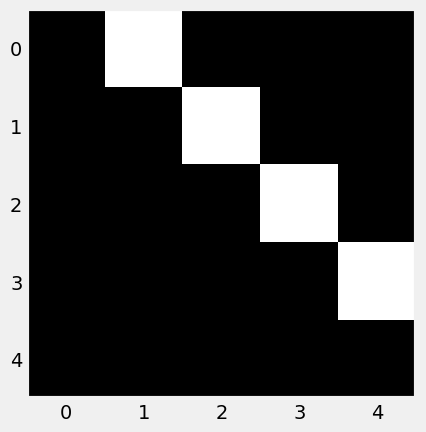

In [26]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

In [27]:
# transforms on image
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

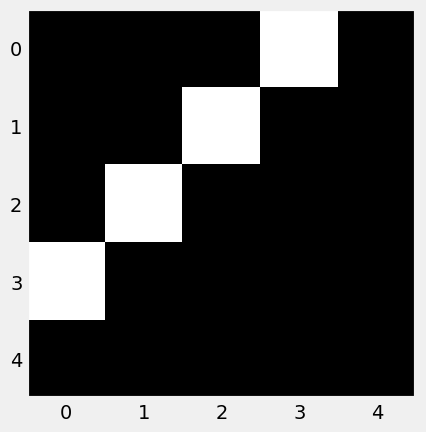

In [28]:
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

In [29]:
# transforms on tensor
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

$$
\Large
\begin{aligned}
\text{input} = 0 \implies \frac{0 - \text{mean}}{\text{std}}= \frac{0 - 0.5}{0.5}&=-1
\\
\text{input} = 1 \implies \frac{1 - \text{mean}}{\text{std}}= \frac{1 - 0.5}{0.5}&=1
\end{aligned}
$$

In [30]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

### Composing Transforms

In [31]:
composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])

In [32]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [33]:
composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

In [34]:
composed_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

In [35]:
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


In [36]:
example_tensor = torch.as_tensor(example / 255).float()

In [37]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

## Data Preparation

### Step 1: Features and labels to tensors

In [38]:
labels.shape

(300,)

In [39]:
# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

### Step 2: Build a custom dataset that is capable of handling transformations


In [40]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [41]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean=(.5,), std=(.5,))])

dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

In [42]:
dataset[1]

(tensor([[[-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1.,  1.]]]),
 tensor([1.]))

### Step 3: Splitting a dataset

In [43]:
# build a custom spliter
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [44]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

In [45]:
train_idx, val_idx = index_splitter(len(x_tensor), [0.8, 0.2])
train_idx

In [46]:
train_idx.indices

[118,
 170,
 148,
 239,
 226,
 146,
 168,
 195,
 6,
 180,
 157,
 2,
 160,
 66,
 46,
 276,
 126,
 212,
 119,
 77,
 53,
 237,
 252,
 202,
 200,
 289,
 135,
 186,
 231,
 211,
 35,
 293,
 229,
 265,
 256,
 134,
 191,
 214,
 8,
 83,
 150,
 190,
 208,
 209,
 275,
 60,
 295,
 142,
 251,
 176,
 260,
 3,
 31,
 0,
 137,
 20,
 81,
 287,
 181,
 129,
 166,
 97,
 110,
 206,
 267,
 241,
 109,
 177,
 27,
 52,
 43,
 245,
 247,
 141,
 68,
 131,
 217,
 78,
 185,
 49,
 96,
 14,
 111,
 234,
 284,
 263,
 269,
 101,
 32,
 285,
 79,
 297,
 94,
 85,
 11,
 5,
 80,
 165,
 183,
 4,
 33,
 100,
 73,
 235,
 277,
 16,
 144,
 132,
 167,
 130,
 45,
 48,
 201,
 99,
 34,
 138,
 178,
 244,
 225,
 173,
 95,
 22,
 197,
 174,
 90,
 223,
 274,
 92,
 279,
 19,
 74,
 28,
 162,
 133,
 151,
 37,
 299,
 18,
 203,
 13,
 156,
 268,
 259,
 116,
 70,
 71,
 230,
 108,
 238,
 47,
 163,
 30,
 188,
 64,
 216,
 121,
 187,
 72,
 221,
 258,
 44,
 179,
 272,
 159,
 253,
 280,
 140,
 120,
 62,
 271,
 57,
 1,
 149,
 9,
 29,
 194,
 158,
 115,
 1

In [47]:
print(len(x_tensor),len(train_idx),len(val_idx))

300 240 60


#### Build a custom sampler

The SubsetRandomSampler samples indices from a list, given as argument, without
replacement. As in the other samplers, these indices are used to load data from a
dataset. If an index is not on the list, the corresponding data point will never be
used.

In [48]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [49]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

In [50]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

#### Leading with an imbalanced dataset: build a weighted sampler

In [51]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [52]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


The class with fewer data points (minority class) should get larger weights, while the class with more data points (majority class) should get smaller weights. This way, on average, we’ll end up with mini-batches containing
roughly the same number of data points in each class: **A balanced dataset**.

In [53]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

In [54]:
y_train_tensor.squeeze().long()

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1])

In [55]:
weights[y_train_tensor.squeeze().long()][:10]

tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])

In [56]:
sample_weights = weights[y_train_tensor.squeeze().long()]

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


In [57]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

In [58]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [59]:
sampler = make_balanced_sampler(y_train_tensor)

#### Data Augmentation Transformations

In [60]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [61]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

In [62]:
train_dataset = TransformedTensorDataset(x_train_tensor,
                                         y_train_tensor,
                                         transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor,
                                       y_val_tensor,
                                       transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

#### Putting It Together

In [63]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor,
                                         y_train_tensor,
                                         transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor,
                                       y_val_tensor,
                                       transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=16,
                          sampler=sampler)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=16)

### Step 4: Pixels as Features

In [64]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [65]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


## Shallow Model

$$
\Large \text{P}(y=1) = \sigma(z) = \sigma(w_0x_0+w_1x_1+\cdots+w_{24}x_{24})
$$

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/classification.png?raw=1)


### Notation

$$
\Large W =
\underset{(25 \times 1)}{
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_{24}
\end{bmatrix}};
X =
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
$$

$$
\Large
\begin{aligned}
z
& = W^T \cdot X
=\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
=
\underset{(1 \times 25)}{
\begin{bmatrix}
w_0 & w_1 & \cdots & w_{24}
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$

### Model Configuration

In [ ]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [ ]:
n_epochs = 100

reg_logistic = Architecture(model_logistic,
                            binary_loss_fn,
                            optimizer_logistic)
reg_logistic.set_loaders(train_loader,
                         val_loader)
reg_logistic.train(n_epochs)

In [ ]:
fig = reg_logistic.plot_losses()

## Deep-ish Model

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/classification_equiv.png?raw=1)

### Model Configuration

In [ ]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [ ]:
n_epochs = 100

arch_nn = Architecture(model_nn, binary_loss_fn, optimizer_nn)
arch_nn.set_loaders(train_loader, val_loader)
arch_nn.train(n_epochs)

In [ ]:
fig = arch_nn.plot_losses()

In [ ]:
def figure5(sbs_logistic, sbs_nn):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(sbs_logistic.losses, 'b--', label='Logistic - Training')
    axs[1].plot(sbs_logistic.val_losses, 'r--', label='Logistic - Validation')
    axs[0].plot(sbs_nn.losses, 'b', label='3-layer Network - Training', alpha=.5)
    axs[1].plot(sbs_nn.val_losses, 'r', label='3-layer Network - Validation', alpha=.5)
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Losses')
    axs[0].set_ylim([0.45, 0.75])
    axs[0].legend()
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Losses')
    axs[1].set_ylim([0.45, 0.75])
    axs[1].legend()
    fig.tight_layout()
    return fig

In [ ]:
fig = figure5(reg_logistic, arch_nn)

### Show Me the Math!

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden}\ \#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden}\ \#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
\\
\hline
\text{substituting } z's... &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
& &
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
& &
& &
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{multiplying...} & &
=
&
\underbrace{
\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}}_{\text{Matrices Multiplied}}
&
& & & & & & & &
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\end{array}
$$

### Show Me the Code!

In [ ]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

In [ ]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

In [ ]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [ ]:
w_logistic_output = model_logistic.output.weight.detach()

w_logistic_output.shape

In [ ]:
reg_logistic.count_parameters(), arch_nn.count_parameters()

### Weights as Pixels

In [ ]:
w_nn_hidden0.shape

In [ ]:
def figure7(weights):
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))

    for i, m in enumerate(weights):
        axs[i].imshow(m.reshape(-1, 5).tolist(), cmap='gray')
        axs[i].grid(False)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(r'$w_{0' + str(i) + '}$')

    fig.suptitle('Hidden Layer #0')
    fig.subplots_adjust(top=0.6)
    fig.tight_layout()
    return fig

In [ ]:
fig = figure7(w_nn_hidden0)

## Activation Functions

### Sigmoid

$$
\Large \sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [ ]:
def plot_activation(func, name=None):
    z = torch.linspace(-5, 5, 1000)
    z.requires_grad_(True)
    func(z).sum().backward()
    sig = func(z).detach()

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    if name is None:
        try:
            name = func.__name__
        except AttributeError:
            name = ''

    if name == 'sigmoid':
        ax.set_ylim([0, 1.1])
    elif name == 'tanh':
        ax.set_ylim([-1.1, 1.1])
    elif name == 'relu':
        ax.set_ylim([-.1, 5.01])
    else:
        ax.set_ylim([-1.1, 5.01])

    ax.set_xticks(np.arange(-5, 6, 1))
    ax.set_xlabel('z')
    ax.set_ylabel(r'$\sigma(z)$')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_title(name, fontsize=16)
    ax.plot(z.detach().numpy(), sig.numpy(), c='k', label='Activation')
    ax.plot(z.detach().numpy(), z.grad.numpy(), c='r', label='Gradient')
    ax.legend(loc=2)

    fig.tight_layout()
    fig.show()
    return fig

In [ ]:
fig = plot_activation(torch.sigmoid)

In [ ]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

In [ ]:
nn.Sigmoid()(dummy_z)

### Hyperbolic Tangent (Tanh)

$$
\Large \sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

In [ ]:
fig = plot_activation(torch.tanh)

In [ ]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

In [ ]:
nn.Tanh()(dummy_z)

### Rectified Linear Unit (ReLU)

$$
\Large
\begin{aligned}
\sigma(z) &=
\begin{cases}
z,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
\\
& \text{or}
\\
\sigma(z) &= \text{max}(0, z)
\end{aligned}
$$

In [ ]:
fig = plot_activation(torch.relu)

In [ ]:
dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

In [ ]:
nn.ReLU()(dummy_z)

In [ ]:
dummy_z.clamp(min=0)

### Leaky ReLU

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
0.01z,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+0.01\ \text{min}(0,z)
\end{aligned}
$$

In [ ]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

In [ ]:
dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

In [ ]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

### Parametric ReLU (PReLU)

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
az,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+a\ \text{min}(0,z)
\end{aligned}
$$

In [ ]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

In [ ]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

In [ ]:
nn.PReLU(init=0.25)(dummy_z)

## Deep Model

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/classification_relu2.png?raw=1)

### Model Configuration

In [ ]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [ ]:
n_epochs = 50

arc_relu = Architecture(model_relu, binary_loss_fn, optimizer_relu)
arc_relu.set_loaders(train_loader, val_loader)
arc_relu.train(n_epochs)

In [ ]:
fig = arc_relu.plot_losses()

In [ ]:
def figure5b(sbs_logistic, sbs_nn, sbs_relu):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(sbs_logistic.losses, 'b--', label='Logistic - Training')
    axs[1].plot(sbs_logistic.val_losses, 'r--', label='Logistic - Validation')

    axs[0].plot(sbs_nn.losses, 'b', label='3-layer Network - Training', alpha=.5)
    axs[1].plot(sbs_nn.val_losses, 'r', label='3-layer Network - Validation', alpha=.5)

    axs[0].plot(sbs_relu.losses, 'b', label='ReLU Network - Training', alpha=.8)
    axs[1].plot(sbs_relu.val_losses, 'r', label='ReLU Network - Validation', alpha=.8)

    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Losses')
    axs[0].legend()
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Losses')
    axs[1].legend()
    fig.tight_layout()
    return fig

In [ ]:
fig = figure5b(reg_logistic, arch_nn, arc_relu)

### Show Me the Math Again!

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden }\#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden }\#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underbrace{
f_0
\underset{(5 \times 1)}{
\left(
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}
\right)}}_{\text{Activation #0}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underbrace{
f_1
\underset{(3 \times 1)}{
\left(
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}
\right)}}_{\text{Activation #1}}
\\
\hline
\text{substituting z's...} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
f_1
& &
\left(
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
\right.
&
&
f_0
& &
\left(
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
\right.
&
&
\left.
\left.
\underbrace{
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}}_{\text{Inputs}}
\right)
\right)
\end{array}
$$

## Putting It All Together

In [ ]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [ ]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [ ]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [ ]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [ ]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(11)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [ ]:
n_epochs = 50

arch_relu = Architecture(model_relu, binary_loss_fn, optimizer_relu)
arch_relu.set_loaders(train_loader, val_loader)
arch_relu.train(n_epochs)

In [ ]:
arch_relu.plot_losses()

In [ ]:
arch_relu.count_parameters()